In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import ProbPlot

from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import matplotlib.pyplot as plt

import seaborn as sns  
sns.set() 
from IPython.display import Image

# Diagnostics

When we fit a linear regression model to a particular data set, many problems may occur. Most common among these are the following:

1. Non-linearity of the response-predictor relationships 
2. Normally distributed errors (outliers).
3. Correlation of error terms.
4. Non-constant variance of error terms (heteroskedasticity).
5. High-leverage points.
6. Multicollinearity.

In many cases of statistical analysis, we are not sure whether our statistical model is correctly specified. For example when using OLS, then linearity and homoscedasticity are assumed, some test statistics additionally assume that the errors are normally distributed or that we have a large sample. Since our results depend on these statistical assumptions, the results are only correct of our assumptions hold (at least approximately).

One solution to the problem of uncertainty about the correct specification is to use robust methods, for example robust regression or robust covariance estimators. The second approach is to test whether our sample is consistent with these assumptions, which we cover in this application.

Sources

- Statsmodels [regression diagnostic page](https://www.statsmodels.org/stable/diagnostic.html) 
- [Statsmodel examples with code](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html)

## Import and inspect data

In [2]:
# Load the csv data files into pandas dataframes
ROOT = "https://raw.githubusercontent.com/kirenz/datasets/master/"
DATA = "Auto.csv"

df = pd.read_csv(ROOT + DATA)

In [3]:
# show the first rows (i.e. head of the DataFrame)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
df.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger
396,31.0,4,119.0,82,2720,19.4,82,1,chevy s-10


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


In [6]:
# show all variables in the data set
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

## Tidying data

In [7]:
# change data type
df['origin'] = pd.Categorical(df['origin'])
df['year'] = pd.Categorical(df['year'], ordered=True)
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce') 

### Handle missing values

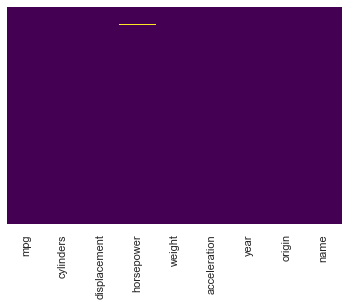

In [8]:
# show missing values (missing values - if present - will be displayed in yellow )
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [9]:
print(df.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64


In [10]:
# there are only 5 missing values therefore we delete the rows
df = df.dropna()

In [11]:
print(df.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64


## Transform data

In [12]:
# summary statistics for all numerical columns
round(df.describe(),2)

,mpg,cylinders,displacement,horsepower,weight,acceleration
count,392.00,392.00,392.00,392.00,392.00,392.00
mean,23.45,5.47,194.41,104.47,2977.58,15.54
std,7.81,1.71,104.64,38.49,849.40,2.76
min,9.00,3.00,68.00,46.00,1613.00,8.00
25%,17.00,4.00,105.00,75.00,2225.25,13.78
50%,22.75,4.00,151.00,93.50,2803.50,15.50
75%,29.00,8.00,275.75,126.00,3614.75,17.02
max,46.60,8.00,455.00,230.00,5140.00,24.80


In [13]:
# summary statistics for all categorical columns
df.describe(include=['category'])

,year,origin
count,392,392
unique,13,3
top,73,1
freq,40,245


## Regression model

In [14]:
# fit linear model with statsmodels.formula.api (with R-style formulas) 
lm = smf.ols(formula ='mpg ~ horsepower', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           7.03e-81
Time:                        21:27:35   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Diagnostics

The `plot_regress_exog` function is a convenience function that gives a 2x2 plot containing 

1. the dependent variable and fitted values with confidence intervals vs. the independent variable chosen, 
2. the residuals of the model vs. the chosen independent variable, 
3. a partial regression plot, 
4. and a CCPR plot. 

This function can be used for quickly checking modeling assumptions with respect to a single regressor ([see statsmodels documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html))

eval_env: 1


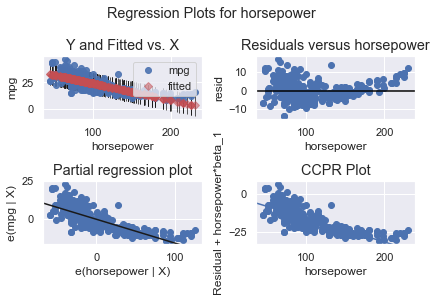

In [15]:
fig = sm.graphics.plot_regress_exog(lm, "horsepower")
fig.tight_layout(pad=1.0)

The plot_fit function plots the fitted values versus a chosen independent variable. It includes prediction confidence intervals and optionally plots the true dependent variable.

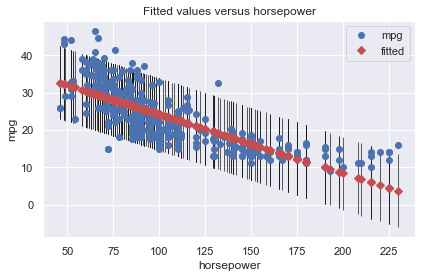

In [38]:
fig = sm.graphics.plot_fit(lm, "horsepower")
fig.tight_layout(pad=1.0)


### Non-linearity

####  Harvey-Collier multiplier test

Harvey-Collier multiplier test for Null hypothesis that the linear specification is correct. This test is a t-test that the mean of the recursive ols residuals is zero. 

A significant result (rejecting the null) occurs when the fit is better with a range restriction (which is what happens if the model is nonlinear).

In [16]:
name = ['t value', 'p value']
test = sm.stats.linear_harvey_collier(lm)

# show result
lzip(name, test)

[('t value', 6.9275846051892005), ('p value', 1.788353466232718e-11)]

###  Residuals vs fitted plot

Residual plots are also a very useful graphical tool for identifying non-linearity:

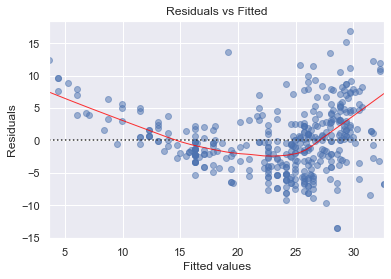

In [17]:
# fitted values
model_fitted_y = lm.fittedvalues

#  Plot
plot = sns.residplot(x=model_fitted_y, y='mpg', data=df, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals');

The residuals are not equally spread around a horizontal line which is an indication for a **non-linear** relationship. 

This means there seems to be a non-linear relationship between the predictor and the response variable which the model doesn’t capture.

**Advanced Plots:**

Besides basic plots, we will also cover some more advanced plots (similar to the R regression diagnostic plots) which flag certain observations. See here for a [description of the R diagnsotic plots](https://data.library.virginia.edu/diagnostic-plots/). 

The code for the advanced plots was obtained from [here](https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034) 

Advanced Residuals vs fitted plot

In [18]:
# Necessary values for our advanced plots:

# fitted values
model_fitted_y = lm.fittedvalues;
# model residuals
model_residuals = lm.resid
# normalized residuals
model_norm_residuals = lm.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)

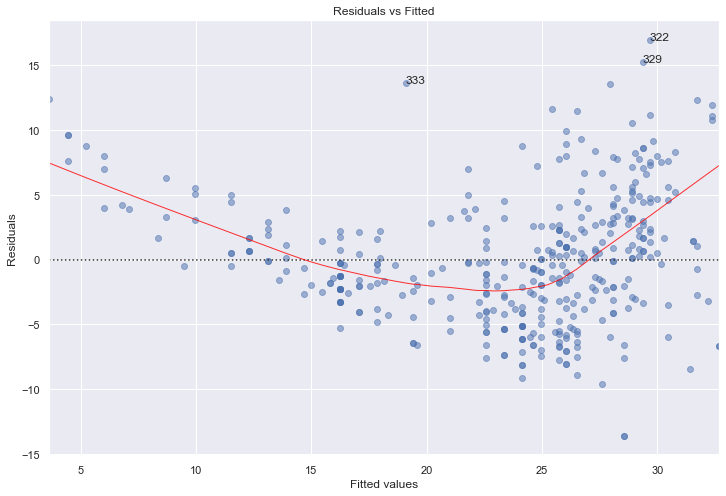

In [19]:
# Advanced plot (1)
# figure size
plot = plt.figure(1)
plot.set_figheight(8)
plot.set_figwidth(12)
# generate figure with sns.residplot 
plot.axes[0] = sns.residplot(x=model_fitted_y, y='mpg', data=df, 
                          lowess=True, scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
# label axes
plot.axes[0].set_title('Residuals vs Fitted')
plot.axes[0].set_xlabel('Fitted values')
plot.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot.axes[0].annotate(i, xy=(model_fitted_y[i], model_residuals[i]));

Deal with non-linearity 

We can fit a non-linear function (polynomial regression)

In [20]:

lm_2 = smf.ols(formula='mpg ~ horsepower + I(horsepower**2)', data=df).fit()
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           5.40e-99
Time:                        21:27:37   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             56.9001      1.800     31.604      0.000      53.360      60.440
horsepower            -0.4662      0.031    -14.978      0.000      -0.527      -0.405
I(horsepower ** 2)     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

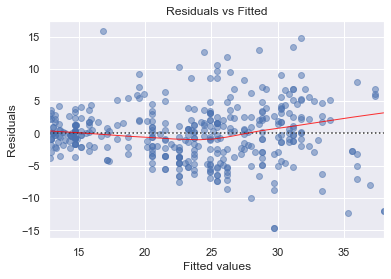

In [21]:
# fitted values
model_fitted_y_2 = lm_2.fittedvalues;
# Basic plot
plot = sns.residplot(x=model_fitted_y_2, y='mpg', data=df, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

plot.set_title('Residuals vs Fitted');
plot.set_xlabel('Fitted values');
plot.set_ylabel('Residuals');

### Normality

It can be helpful if the residuals in the model are random, normally distributed variables with a mean of 0. 

This assumption means that the differences between the predicted and observed data are most frequently zero or very close to zero, and that differences much greater than zero happen only occasionally.

Some people confuse this assumption with the idea that predictors have to be normally distributed, which they don’t. In small samples a lack of normality invalidates confidence intervals and significance tests, whereas in large samples it will not because of the **central limit theorem**. 

If you are concerned only with estimating the model parameters (and not significance tests and confidence intervals) then this assumption barely matters. If you bootstrap confidence intervals then you can ignore this assumption.

#### Jarque-Bera test

The Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. 

The null hypothesis is a joint hypothesis of the skewness being zero and the excess kurtosis being zero. 

Samples from a normal distribution have an expected skewness of 0 and an expected excess kurtosis of 0 (which is the same as a kurtosis of 3). As the definition of JB shows, any deviation from this increases the JB statistic.

In [22]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(lm.resid)

lzip(name, test)

[('Jarque-Bera', 17.304523605194955),
 ('Chi^2 two-tail prob.', 0.00017473119341274493),
 ('Skew', 0.49249294068386334),
 ('Kurtosis', 3.2987698820090974)]

#### Omnibus normtest

Test for normal distribution of residuals. In this case, we use the $Chi^2$-Test. The Chi-Square Test for normality allows us to check whether or not the model residuals follow an approximately normal distribution.

Our null hypothesis is that the residuals are from a normal distribution.

In [23]:
name = ['Chi^2', 'Two-tail probability']
test = sm.stats.omni_normtest(lm.resid)
lzip(name, test)

[('Chi^2', 16.432334104701702),
 ('Two-tail probability', 0.0002702489322697913)]

### Outliers

An outlier is a point for which $y_i$ is far from the value predicted by the model. Outliers can arise for a variety of reasons, such as incorrect recording of an observation during data collection.

In practice, it can be difficult to decide how large a residual needs to be before we consider the point to be an outlier. To address this problem, instead of plotting the residuals, we can plot the studentized residuals, computed by dividing each residual by its estimated standard error. 

Observations whose studentized residuals are greater than 3 in absolute value are possible outliers. 

If we believe that an outlier has occurred due to an error in data collection or recording, then one solution is to simply remove the observation. However, care should be taken, since an outlier may instead indicate a deficiency with the model, such as a missing predictor.

#### Normal Q-Q-Plot

This plots the standardized (z-score) residuals against the theoretical normal quantiles. Anything quite off the diagonal lines may be a concern for further investigation.

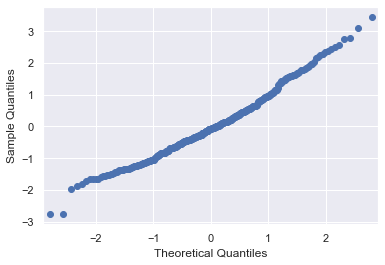

In [24]:
# Use standardized residuals
sm.qqplot(lm.get_influence().resid_studentized_internal);

This plot shows if residuals are normally distributed. If a normal distribution is present, the residuals should (more or less) follow a straight line. 
We can observe that only some residuals (in the lower left and the upper right corner) deviate from the straight line. 

We could obtain the 3 observations with the largest deviations from our advanced plot below (observations 330, 327 and 320). 

**Advanced QQ-Plot**

/Users/jankirenz/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


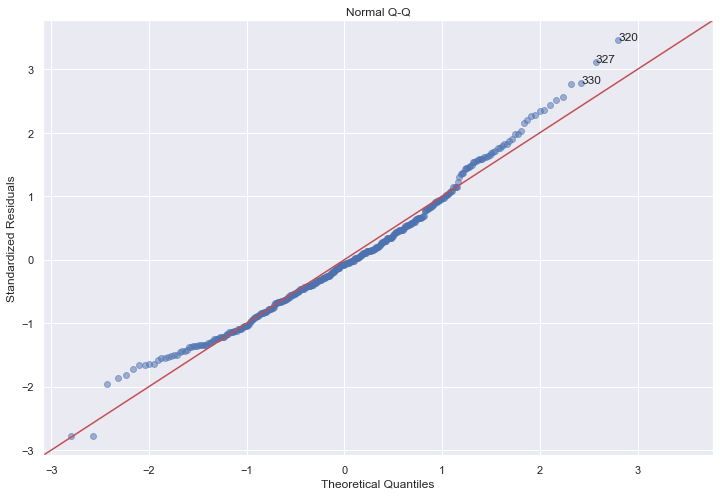

In [25]:
# Advanced plot (2)
# ProbPlot and its qqplot method from statsmodels graphics API. 
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
# figure size
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
# figure labels
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
# label 3 largest deviations
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

### Correlation

An important assumption of the linear regression model is that the error terms are uncorrelated.

Such correlations frequently occur in the context of time series data, which consists of observations for which measurements are obtained at discrete points in time. In many cases, observations that are obtained at adjacent time points will have positively correlated errors. In order to determine if this is the case for a given data set, we can plot the residuals from our model as a function of time. If the errors are uncorrelated, then there should be no discernible pattern.

Correlation among the error terms can also occur outside of time series data. For instance, consider a study in which individuals’ heights are predicted from their weights. The assumption of uncorrelated errors could be violated if some of the individuals in the study are members of the same family, or eat the same diet, or have been exposed to the same environmental factors. 

In general, the assumption of uncorrelated errors is extremely important for linear regression as well as for other statistical methods, and good experimental design is crucial in order to mitigate the risk of such correlations.

A test of autocorrelation that is designed to take account of the regression model is the **Durbin-Watson test**. It is used to test the hypothesis that there is no **lag one autocorrelation** in the residuals. If there is no autocorrelation, the Durbin-Watson distribution is symmetric around 2. 

A small p-value indicates there is significant autocorrelation remaining in the residuals.

As a rough rule of thumb, if Durbin–Watson is less than 1.0, there may be cause for alarm. Small values of d indicate successive error terms are positively correlated. If d > 2, successive error terms are negatively correlated.

In [26]:
sm.stats.durbin_watson(lm.resid)

0.9195392995415309

### Variance of error terms


Another important assumption of the linear regression model is that the error terms have a constant variance. 

For instance, the variances of the error terms may increase with the value of the response. One can identify non-constant variances in
the errors, or **heteroscedasticity**, from the presence of a funnel shape in the residual plot. 

When faced with this problem, one possible solution is to transform the response Y using a concave function such as log Y or √Y . Such a transformation results in a greater amount of shrinkage of the larger responses, leading to a reduction in heteroscedasticity.

#### Breusch-Pagan test:

Test assumes homoskedasticity (null hypothesis). If one of the test statistics is significant, then you have evidence of heteroskedasticity. 

In [27]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(lm.resid, lm.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 8.753469480137834),
 ('p-value', 0.003090136011371003),
 ('f-value', 8.907720815170773),
 ('f p-value', 0.0030184985629867433)]

#### Scale-Location plot

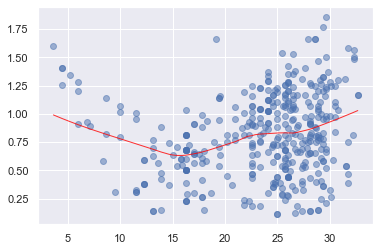

In [28]:
# Scale Location plot
plt.scatter(x=model_fitted_y, y=model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

This plot shows if residuals are spread equally along the ranges of predictors. This is how we can check the assumption of equal variance (**homoscedasticity**). It’s good if we observe a horizontal line with equally (randomly) spread points.

In our model the residuals begin to spread wider along the y-axis as it passes the x value of around 18. Because the residuals spread wider and wider with an increase of x, the red smooth line is not horizontal and shows a positive angle. This is an indication of **heteroskedasticity**.

### Leverage

We just saw that outliers are observations for which the response $y_i$ is unusual given the predictor $x_i$. In contrast, observations with high leverage have an unusual value for $x_i$. 

In a simple linear regression, high leverage observations are fairly easy to identify, since we can simply look for observations for which the predictor value is outside of the normal range of the observations. But in a multiple linear regression with many predictors, it is possible to have an observation that is well within the range of each individual predictor’s values, but that is unusual in terms of the full set of predictors.

A general rule of thumb is that observations with a **Cook’s D** over 4/n, where n is the number of observations, is a possible outlier. 

#### Statsmodel influence

Once created, an object of class OLSInfluence holds attributes and methods that allow users to assess the influence of each observation. 

In [29]:
# obtain statistics
infl = lm.get_influence()

In [30]:
lm_cooksd = lm.get_influence().cooks_distance[0]
n = len(df["name"])
critical_d = 4/n
print('Critical Cooks d:', critical_d)
#identification of potential outliers
out_d = lm_cooksd > critical_d
# Output potential outliers
df.index[out_d],lm_cooksd[out_d]

Critical Cooks d: 0.01020408163265306


(Int64Index([  5,   6,   7,   8,  13,  59,  94,  95, 116, 154, 155, 244, 247,
             309, 322, 324, 325, 326, 329, 333, 393],
            dtype='int64'),
 array([0.01516703, 0.04326643, 0.03298054, 0.05570847, 0.05570847,
        0.01035856, 0.02525141, 0.03487463, 0.10045073, 0.01687185,
        0.01687185, 0.01962219, 0.01066571, 0.01521074, 0.03151222,
        0.01361433, 0.02425169, 0.02073364, 0.02424383, 0.01494484,
        0.02318925]))

In [31]:
# Show summary frame of leverage statistics
print(infl.summary_frame().filter(["student_resid","dffits","cooks_d"]))

     student_resid    dffits   cooks_d
0        -0.288842 -0.017545  0.000154
1         0.226696  0.021453  0.000231
2         0.355552  0.027922  0.000391
3        -0.052921 -0.004156  0.000009
4        -0.170930 -0.011784  0.000070
..             ...       ...       ...
392       0.130252  0.007310  0.000027
393       2.528043  0.216840  0.023189
394       1.087106  0.062308  0.001940
395       0.108888  0.006609  0.000022
396       0.817933  0.047933  0.001150

[392 rows x 3 columns]


#### Residuals vs leverage

Plots leverage statistics vs. normalized residuals squared. See [statsmodel documentation](http://www.statsmodels.org/0.6.1/generated/statsmodels.graphics.regressionplots.plot_leverage_resid2.html)

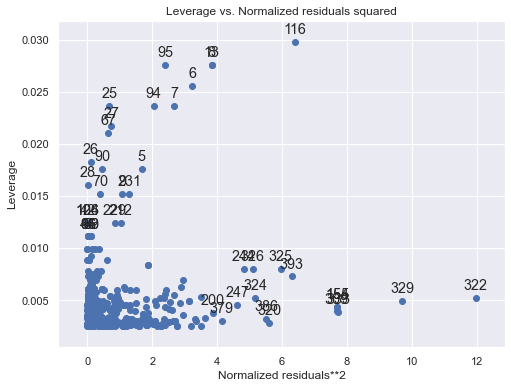

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(lm, ax = ax)

### Multicollinearity

Collinearity refers to the situation in which two or more predictor variables collinearity are closely related to one another.

The presence of collinearity can pose problems in the regression context, since it can be difficult to separate out the individual effects of collinear variables on the response. 

In other words, since limit and rating tend to increase or decrease together, it can be difficult to determine how each one separately is associated with the response, balance.

/Users/jankirenz/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


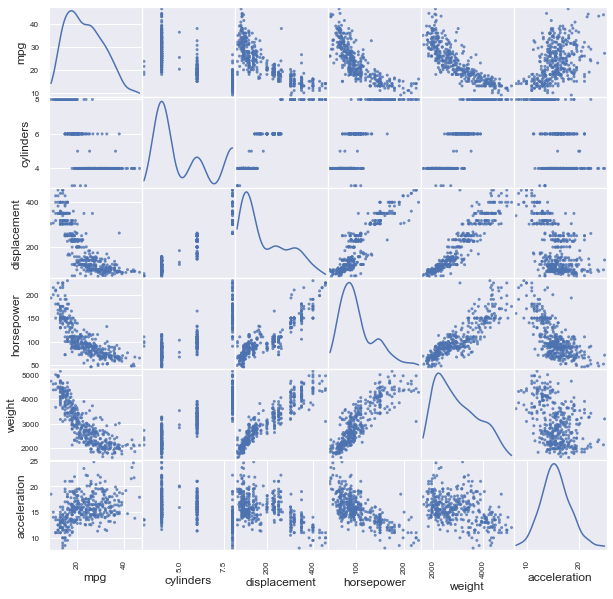

In [33]:
# plot all variables in a scatter matrix
pd.plotting.scatter_matrix(df, alpha=0.8, figsize=(10, 10), diagonal='kde');

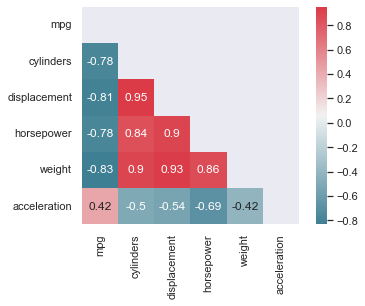

In [34]:
# Inspect correlation
# Calculate correlation using the default method ( "pearson")
corr = df.corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 12});

A simple way to detect collinearity is to look at the **correlation matrix** of the predictors. An element of this matrix that is large in absolute value indicates a pair of highly correlated variables, and therefore a collinearity problem in the data. 

Unfortunately, not all collinearity problems can be detected by inspection of the correlation matrix: it is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation. We call this situation **multicollinearity**. 

Instead of inspecting the correlation matrix, a better way to assess multicollinearity is to compute the condition number test. If the condition number is above 30, the regression may have significant multicollinearity.

In [35]:
# makes here no sense since we only have one predictor...
np.linalg.cond(lm.model.exog)

322.3691031299227

Instead of inspecting the correlation matrix, a better way to assess multicollinearity is to compute the variance inflation factor (VIF). The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. Typically in practice there is a small amount of collinearity among the predictors. As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity.

In [36]:
y, X = dmatrices('mpg ~ horsepower+ cylinders + displacement', df, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.round(2)

,VIF Factor,Feature
0,33.62,Intercept
1,5.16,horsepower
2,10.48,cylinders
3,15.56,displacement


When faced with the problem of collinearity, there are two simple solutions: 

The first is to drop one of the problematic variables from the regression. This can usually be done without much compromise to the regression fit, since the presence of collinearity implies that the information that this variable provides about the response is redundant in the presence of the other variables. 

The second solution is to combine the collinear variables together into a single predictor. For instance, we might take the average of standardized versions of limit and rating in order to create a new variable that measures credit worthiness.